In [61]:
import sys; sys.path.insert(0,'../')
from dist_tools import *

%matplotlib inline

In [62]:
pd.options.display.max_rows = 10000

In [63]:
fips, epsg, seats = 24, 3559, 8

#### This is just a correspondence between FIPS codes and Maryland's own county numbering system.  Because, you know, why not?

In [64]:
md_co_map = pd.read_csv("/media/jsaxon/brobdingnag/data/el_dv/md_site/md_precinct_reference_2000.csv")
md_co_map = md_co_map.rename(columns = {"County ID" : "md_id", "County Name" : "county"})[["md_id", "county"]]
md_co_map.drop_duplicates(keep = "first", inplace = True)
md_co_map.county = md_co_map.county.str.upper()

md_co_census = pd.read_sql("""SELECT DISTINCT 
                                  county cid, 
                                  REGEXP_REPLACE(REGEXP_REPLACE(
                                      UPPER(name), ' PRECINCT.*', ''), 
                                                   'ST\.', 'SAINT') county
                              FROM vtd_2010
                              WHERE state = 24 AND vtd != 'ZZZZZZ'
                              ORDER BY cid;""",
                           con = psycopg2.connect(database = "census", user = user, password = passwd,
                                                  host = "saxon.harris.uchicago.edu", port = 5432))

md_co_map = pd.merge(md_co_map, md_co_census, on = "county", how = "outer")[["cid", "md_id"]] # , "county"]]

We're getting the precinct shapes directly from the Census 2010 VTDs.

In [65]:
query = """SELECT 
              vtd.county cid,
              REGEXP_REPLACE(vtd, '-.*', '')::int ed,
              REGEXP_REPLACE(vtd, '.*-', '')::int precinct, vtd.geoid,
              ST_Transform(vtd.geom, 3559) geometry
           FROM vtd_2010 AS vtd
           WHERE vtd.state = 24 AND vtd != 'ZZZZZZ'
           ORDER BY vtd.county, ed, precinct;
           """

con = psycopg2.connect(database = "census", user = user, password = passwd,
                       host = "saxon.harris.uchicago.edu", port = 5432)

pr_tr = gpd.GeoDataFrame.from_postgis(query, con, geom_col = "geometry", crs = from_epsg(epsg))

pcts = pr_tr[['cid', 'ed', 'precinct', 'geoid']]

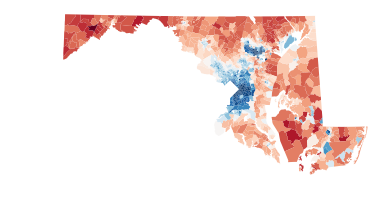

In [66]:
votes08 = pd.read_csv("/media/jsaxon/brobdingnag/data/el_dv/precincts/MD_2008.tab", sep = "\t")
votes08 = votes08[["county", "ed", "precinct", "g2008_USP_dv", "g2008_USP_rv"]].astype(int)
votes08.rename(inplace = True, columns = {"g2008_USP_dv" : "D08", "g2008_USP_rv" : "R08",
                                           "county" : "md_id"})
votes08 = votes08[(votes08["D08"] > 0) | (votes08["D08"] > 0)]

## Replace the stupid Maryland county IDs with a real FIPS ones.
votes08 = pd.merge(votes08, md_co_map, on = "md_id")[["cid", "ed", "precinct", "D08", "R08"]]
votes08.sort_values(by = ["cid", "ed", "precinct"], inplace = True)

votes08.loc[((votes08.cid == 23) | (votes08.cid == 43)) & (votes08.precinct == 0), "precinct"] = 1

votes08 = pd.merge(votes08, pcts, on = ["cid", "ed", "precinct"], how = "left")

## A few places with new precincts: assign them to the original spot.
votes08.loc[(votes08.cid == 13) & votes08.geoid.isnull(), "precinct"] = 1
votes08 = votes08[["cid", "ed", "precinct", "D08", "R08"]]

votes08 = pr_tr.merge(votes08, on = ["cid", "ed", "precinct"], how = "right")

votes08["DFrac"] = votes08.D08 / (votes08.D08 + votes08.R08)
votes08.plot(column = "DFrac", cmap = "RdBu").set_axis_off()

votes08.to_file("/media/jsaxon/brobdingnag/data/el_dv/precincts/md_2008.shp")

output_geojson(votes08.set_geometry(votes08.geometry.simplify(10)),
               var = "DFrac", fname = "mapped/md_2008.geojson")

The census geocoder gives a really low match rate, here.  Use google's -- 2.5k per day, so one shot per day!

Start by adding in all the neccesary variables on the addresses of the polling places.

In [74]:
md_precincts_2016 = pd.read_excel("/media/jsaxon/brobdingnag/data/el_dv/md_site/md_precinct_reference_2016.xls",
                                  skiprows = [1], usecols = ["COUNTY", "ELECTION_DISTRICT", "PRECINCT", "ADDRESS1", "CITY", "ST", "ZIP"])
md_precincts_2016.rename(columns = {"COUNTY" : "md_id", "ELECTION_DISTRICT" : "ed", "PRECINCT" : "precinct",
                                    "ADDRESS1" : "address", "CITY" : "city", "ST" : "st",  "ZIP" : "zip"}, 
                         inplace = True)
md_precincts_2016 = md_precincts_2016[  ~md_precincts_2016.zip.isnull() \
                                      & ~md_precincts_2016.ed.isnull() \
                                      & ~md_precincts_2016.precinct.isnull() \
                                      & ~md_precincts_2016.address.isnull()]
md_precincts_2016.ed = md_precincts_2016.ed.astype(int)
md_precincts_2016.precinct = md_precincts_2016.precinct.astype(int)
md_precincts_2016.zip = abs(md_precincts_2016.zip.fillna(0).astype(int))
md_precincts_2016 = pd.merge(md_precincts_2016, md_co_map, on = "md_id")
md_precincts_2016 = md_precincts_2016.sort_values(by = ["cid", "ed", "precinct"])
md_precincts_2016 = md_precincts_2016.reset_index()[["md_id", "cid", "ed", "precinct", "address", "city", "st", "zip"]]
md_precincts_2016 = md_precincts_2016.drop_duplicates()

md_precincts_2016[["address", "city", "st", "zip"]].to_csv("/media/jsaxon/brobdingnag/data/el_dv/md_site/md_precinct_addr_2016.csv",
                                                           index = False, header = False)

Unless we're rebuilding from scratch, we can just merge back on the latitudes and longitudes.

In [75]:
md_bak = pd.read_csv("/media/jsaxon/brobdingnag/data/el_dv/md_site/md_2016_geocoded.csv", 
                     usecols = ["cid", "ed", "precinct", "lat", "lon"],
                     dtype = {"cid" : int, "ed" : float, "precinct" : float, "lat" : float, "lon" : float})

In [76]:
md_2016 = pd.read_csv("/media/jsaxon/brobdingnag/data/el_dv/md_site/md_state_2016.csv", 
                      usecols = ["County", "Election District", "Election Precinct", 
                                 "Candidate Name", "Election Night Votes", "Office Name"], low_memory = False)
md_2016.rename(columns = {"County" : "md_id", "Election District" : "ed", "Election Precinct" : "precinct",
                          "Candidate Name" : "candidate", "Office Name" : "office", "Election Night Votes" : "votes"}, 
               inplace = True)
md_2016 = md_2016[(md_2016.candidate == "Donald J. Trump") | (md_2016.candidate == "Hillary Clinton")]
md_2016["party"] = "R16"
md_2016.loc[md_2016.candidate == "Hillary Clinton", "party"] = "D16"
md_2016 = pd.pivot_table(md_2016, values = "votes", index = ["md_id", "ed", "precinct"], columns = ["party"])
md_2016 = md_2016[(md_2016.D16 > 0) | (md_2016.R16 > 0)]
md_2016 = md_2016.reset_index()
md_2016 = pd.merge(md_2016, md_precincts_2016, on = ["md_id", "ed", "precinct"], how = "outer")
md_2016 = md_2016[["cid", "ed", "precinct", "D16", "R16", "address", "city", "st", "zip"]]
md_2016 = md_2016.sort_values(by = ["cid", "ed", "precinct"])
md_2016.D16 = md_2016.D16.fillna(0)
md_2016.R16 = md_2016.R16.fillna(0)
# md_2016["lat"] = 0
# md_2016["lon"] = 0

md_2016 = md_2016.merge(md_bak[["cid", "ed", "precinct", "lat", "lon"]], on = ["cid", "ed", "precinct"], how = "outer")

In [77]:
md_2016.loc[md_2016.address == "310 Governor William Stone Parkway", "address"] = "310 Governor Stone Pkwy"
md_2016.loc[md_2016.address == "5752 Rhodes-Eldorado Road",          "address"] = "5752 Rhodesdale Eldorado Rd"
md_2016.loc[md_2016.address == "5745 Cloverdale Road",               "city"   ] = "Hurlock"
md_2016.loc[md_2016.address == "1330 Route 94 Woodbine Rd",          "address"] = "1330 Woodbine Rd"
md_2016.loc[md_2016.address == "12101 Route 108 Clarksville Pike",   "address"] = "12101 Clarksville Pike"
md_2016.loc[md_2016.address == "302 University & Academy Avenues",   "address"] = "302 University Ave N"
md_2016.loc[md_2016.address == "ROUTE 1 & ROSSBOROUGH LANE",         "address"] = "7675 Baltimore Ave"
md_2016[md_2016.lat.isnull() | (md_2016.lat == 0)]

,cid,ed,precinct,D16,R16,address,city,st,zip,lat,lon


In [78]:
google_user, google_acct, google_key = netrc().authenticators("google-location")

gmaps_api = "https://maps.googleapis.com/maps/api/geocode/json?address={}&key=%s" % google_key

import math
import time
import requests

for ri, row in []: # md_2016.iterrows():
    
    if not math.isnan(row.lat): continue

    addr = ", ".join([row.address, row.city, row.st, str(row.zip)]).replace(" ", "+")
    print(ri, gmaps_api.format(addr))
    resp = None # requests.get(gmaps_api.format(addr))
    try:
        md_2016.loc[ri, "lat"] = resp.json()["results"][0]["geometry"]["location"]["lat"]
        md_2016.loc[ri, "lon"] = resp.json()["results"][0]["geometry"]["location"]["lng"]
    except: pass
    
    if (ri % 40) == 0: time.sleep(1)


In [79]:
# md_2016.to_csv("/media/jsaxon/brobdingnag/data/el_dv/md_site/md_2016_geocoded.csv")

In [88]:
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(md_2016.lon, md_2016.lat)]
votes16 = gpd.GeoDataFrame(md_2016, crs = from_epsg(4269), geometry = geometry).to_crs(epsg = epsg)

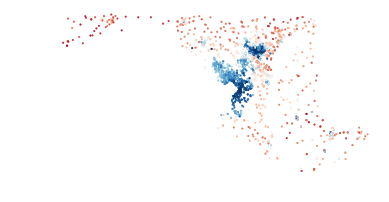

In [89]:
votes16["DFrac"] = votes16.D16 / (votes16.D16 + votes16.R16)
votes16["marker-size"] = "small"
# votes16["marker-symbol"] = "circle-11.svg"

votes16.head()

colors = plt.get_cmap("RdBu")

votes16["marker-color"] = "#000000"
for ri, row in votes16.iterrows():

    if np.isnan(row["DFrac"]): continue

    color = [int(v*255) for v in plt.get_cmap("RdBu")(row["DFrac"])][:3]
    votes16.loc[ri, "marker-color"] = "#{0:02X}{1:02X}{2:02X}".format(*color)

ax = votes16.plot(column = "DFrac", cmap = "RdBu", markersize = 3)
ax.set_axis_off()

output_geojson(votes16, var = "DFrac", fname = "mapped/md_2016.geojson")

Now merge the geocoded polling locations onto the overlapping census tract shapes.

In [90]:
votes16.crs

{'init': 'epsg:3559', 'no_defs': True}

In [91]:
query = """SELECT rn, ST_Transform(tr.geom, epsg) geometry
           FROM census_tracts_2015 AS tr
           JOIN (SELECT state, county, tract,
                        row_number() over (PARTITION BY state ORDER BY county, tract NULLS LAST) - 1 as rn
                 FROM census_tracts_2015) rn ON
              tr.state  = rn.state AND tr.county = rn.county AND tr.tract  = rn.tract
           JOIN states AS st ON st.fips = tr.state
           WHERE tr.state = 24;"""

con = psycopg2.connect(database = "census", user = user, password = passwd,
                       host = "saxon.harris.uchicago.edu", port = 5432)

tr_rn = gpd.GeoDataFrame.from_postgis(query, con, geom_col = "geometry", crs = from_epsg(epsg))

In [96]:
tr_votes_2008 = merge_tract_number(tr_rn, votes08)[["D08", "R08"]]
tr_votes_2016 = merge_tract_number(tr_rn, votes16)[["D16", "R16"]]
tr_votes = tr_votes_2008.join(tr_votes_2016, how = "outer").fillna(0).astype(int)
tr_votes.to_csv("votes/md.csv")

Sanity check: did we preserve all of the votes from beginning to end?

In [100]:
test08 = pd.read_csv("/media/jsaxon/brobdingnag/data/el_dv/precincts/MD_2008.tab", sep = "\t")
test16 = pd.read_csv("/media/jsaxon/brobdingnag/data/el_dv/md_site/md_state_2016.csv", 
                   usecols = ["County", "Election District", "Election Precinct", 
                              "Candidate Name", "Election Night Votes", "Office Name"], low_memory = False)

if not tr_votes.D08.sum() == test08.g2008_USP_dv.sum():
    print("problems in paradise -- 2008!!")
if not tr_votes.D16.sum() == test16[test16["Candidate Name"] == "Hillary Clinton"]["Election Night Votes"].sum():
    print("2016 is fucked.")
else: print("nice work, stud.")

nice work, stud.
